# Predicción de preferencias de música con KNN
Comienzo leyendo el dataset:

In [ ]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
print('Rows:', df.shape[0], '\nCols:', df.shape[1])
df.head()

Rows: 2017 
Cols: 17


,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


El dataset está compuesto por 13 atributos numéricos, 2 atributos de texto y el target. Comenzaré desarrollando un clasificador que utilice sólo los atributos numéricos. Si bien se podría encontrar alguna correlación entre el nombre de la canción y el artista con el target (como por ejemplo la cantidad de sílabas del nombre), resultaría complicado y no pareciera en primera instancia que aporte mucha información al modelo.

En primer lugar, analizo la distribución de cada atributo para luego normalizar los valores.

In [ ]:
import seaborn as sns

df = df.drop(labels=['Unnamed: 0', 'song_title', 'artist'], axis=1)
sns.pairplot(df, hue='target')

Output hidden; open in https://colab.research.google.com to view.

Como se puede ver en el gráfico anterior, hay atributos que tienen rangos de valores muy grandes en comparación con otros. Dado que KNN depende de la distancia entre puntos, podría ser beneficioso normalizar los atributos. Se prueban dos normalizaciones: una de ellas consiste en mapear linealmente los valores al rango [0,1] utilizando percentiles como valores máximos y mínimos; la otra consiste en estandarizar los valores para que tengan media cero y varianza uno.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Parámetros para separar y normalizar el dataset
test_fraction = 0.2
prctile_low = 0.01
prctile_high = 99.9

# Separo el dataset en entrenamiento y validación
X_train,  X_test,  y_train,  y_test  = train_test_split(df.drop('target', axis=1), df.target, test_size=test_fraction, random_state=50)

# Normalización al rango [0,1]
X_train_norm, X_test_norm = (X_train.copy(), X_test.copy())
for col in X_train_norm.columns:
    x_min, x_max = np.percentile(X_train_norm[col], [prctile_low, prctile_high])
    X_train_norm[col] = np.clip((X_train_norm[col]-x_min)/(x_max-x_min), 0, 1)
    X_test_norm[col]  = np.clip((X_test_norm[col]-x_min)/(x_max-x_min), 0, 1)

# Estandarización a media 0 y varianza 1
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


Finalmente instancio el modelo, lo entreno y analizo los resultados. Utilizo GridSearch para determinar los mejores hiperparámetros. Para seleccionar la mejor normalización de los datos comparo el mejor score (accuracy) obtenido con cada una.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

grid_params = {'n_neighbors': [3,5,7,11,15,21,27,35,49],
               'weights': ['uniform', 'distance'],
               'metric': ['euclidean', 'manhattan', 'chebyshev']}

gs_norm = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=4, n_jobs=-1)
gs_std  = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=4, n_jobs=-1)
gs_norm_results = gs_norm.fit(X_train_norm, y_train)
gs_std_results  = gs_std.fit(X_train_std, y_train)

print('\nScore using normalized dataset:', gs_norm_results.best_score_)
print('Best parameters:', gs_norm_results.best_params_, '\n')
print('Score using standarized dataset:', gs_std_results.best_score_)
print('Best parameters:', gs_std_results.best_params_, '\n')

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.6s



Score using normalized dataset: 0.6999468712379924
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'} 

Score using standarized dataset: 0.71792619708621
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'} 



[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    4.5s finished


El score para los datos estandarizados a media cero y varianza uno es ligeramente mayor, por lo cual se utiliza el modelo entrenado con ese dataset. Se calculan entonces las métricas para el set de testeo:

Accuracy: 0.609
Recall: 0.667
Precision: 0.596
F1 score: 0.629 



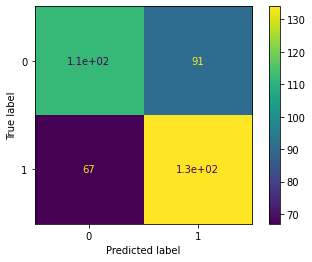

In [ ]:
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

knn_best = gs_std_results.best_estimator_
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

print('Accuracy:', np.round(accuracy_score(y_test, y_pred), 3))
print('Recall:', np.round(recall_score(y_test, y_pred), 3))
print('Precision:', np.round(precision_score(y_test, y_pred), 3))
print('F1 score:', np.round(f1_score(y_test, y_pred), 3), '\n')

# Grafico la matriz de confusión
plot_confusion_matrix(knn_best, X_test, y_test)

Como se puede ver, en el set de validación (interno de GridSearch) la exactitud (accuracy) media es de 0.718, mientras que en el set de testeo es de 0.609. En base a este último resultado, se podría decir que en aproximadamente el 60% de los casos el modelo podría predecir si la canción le gusta o no al usuario, lo cual no parece un buen resultado comparado con el 50% que se obtiene ante una decisión aleatoria. Para mejorar este resultado habría que probar con otro modelo.